**this kernel was forked from here : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing?scriptVersionId=20265194

i got 0.657 using densenet201(in version 3) **

i tried  efficientnetb4 but it failed for large image size,so i will try efficientnetb3 now with bce dice loss
if you find this kernel useful,please upvote,your upvote motivates kagglers like us to share things publicly,thanks

**Version 13**

- updating previously used submission.csv with version 3's generated submission file which achieved 0.657

- threshold = 0.9

- efficientnetb2

- loss='categorical_crossentropy', metrics=['accuracy']

# Intro
In this notebook I'd create a classifier to distinguish types of cloud formations. Using this classifier I'd check if it improves currently the best LB score from the great [public notebook by Jan](https://www.kaggle.com/jpbremer/efficient-net-b4-unet-clouds). 

# Plan
1. [Libraries](#Libraries)
2. [Data Generators](#Data-Generators)
  * [One-hot encoding classes](#One-hot-encoding-classes)
  * [Stratified split into train/val](#Stratified-split-into-train/val)
  * [Generator class](#Generator-class)
3. [PR-AUC-based Callback](#PR-AUC-based-Callback)
4. [Classifier](#Classifier)
  * [Defining a model](#Defining-a-model)
  * [Initial tuning of the added fully-connected layer](#Initial-tuning-of-the-added-fully-connected-layer)
  * [Fine-tuning the whole model](#Fine-tuning-the-whole-model)
  * [Visualizing train and val PR AUC](#Visualizing-train-and-val-PR-AUC)
5. [Selecting postprocessing thresholds](#Selecting-postprocessing-thresholds)
6. [Post-processing segmentation submission](#Post-processing-segmentation-submission)
7. [Future work](#Future-work)

# Libraries

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

Using TensorFlow backend.


In [2]:
!pip install keras-rectified-adam

  Stored in directory: C:\Users\Einstein\AppData\Local\pip\Cache\wheels\7b\01\27\3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [3]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [4]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [5]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Fish, Sugar, Flower}",1,1,1,0
2,0031ae9.jpg,"{Fish, Sugar, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Gravel, Fish, Sugar}",1,0,1,1


In [6]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [7]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=17)

## Generator class

In [21]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=260, resized_width=260, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_height, self.resized_width), interpolation=cv2.INTER_AREA).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [22]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [23]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False)
data_generator_val = DataGenenerator(val_imgs, shuffle=False)

# PR-AUC-based Callback

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [11]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=5, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] # to store per each class and also mean PR AUC
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        if len(self.history[-1]) > patience:
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        if self.is_patience_lost(self.early_stopping_patience):
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        if pr_auc_mean > self.best_pr_auc:
            # remove previous checkpoints to save space
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'efficientNetB3_260x260_epoch_*')):
                os.remove(checkpoint)
            self.best_pr_auc = pr_auc_mean
            self.model.save(os.path.join(self.checkpoints_path, f'efficientNetB3_260x260_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
            print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
        # estimate AUC under precision recall curve for each class
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            # early stop after early_stopping_patience=4 epochs of no improvement in mean PR AUC
            self.early_stopping_check(pr_auc_mean)

            # save a model with the best PR AUC in validation
            self.model_checkpoint(pr_auc_mean, epoch)

            # reduce learning rate on PR AUC plateau
            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

Callback instances

In [12]:
train_metric_callback = PrAucCallback(data_generator_train_eval)
val_callback = PrAucCallback(data_generator_val, stage='val')

# Classifier

## Defining a model

In [13]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [14]:
DELETE !pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to c:\users\einstein\appdata\local\temp\pip-req-build-am20l296


  Error [WinError 2] The system cannot find the file specified while executing command git clone -q https://github.com/qubvel/efficientnet C:\Users\Einstein\AppData\Local\Temp\pip-req-build-am20l296
Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [15]:
!pip install -U --pre efficientnet

In [16]:
import efficientnet.keras as efn 
def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB3(weights='imagenet', include_top=False, pooling='avg', input_shape=(260, 260, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 52s - ETA: 49 - ETA: 44 - ETA: 44 - ETA: 41 - ETA: 41 - ETA: 39 - ETA: 38 - ETA: 39 - ETA: 37 - ETA: 37 - ETA: 39 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA:

In [17]:
from keras_radam import RAdam

## Initial tuning of the added fully-connected layer

In [19]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = False
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_0 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=10,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/10
138/138 [==============================] - ETA: 35:40 - loss: 3.1071 - acc: 0.31 - ETA: 18:00 - loss: 3.0224 - acc: 0.31 - ETA: 12:07 - loss: 2.9138 - acc: 0.30 - ETA: 9:10 - loss: 2.8477 - acc: 0.2812 - ETA: 7:24 - loss: 2.8591 - acc: 0.287 - ETA: 6:13 - loss: 2.8263 - acc: 0.296 - ETA: 5:23 - loss: 2.8084 - acc: 0.299 - ETA: 4:45 - loss: 2.8260 - acc: 0.293 - ETA: 4:15 - loss: 2.7812 - acc: 0.312 - ETA: 3:52 - loss: 2.7937 - acc: 0.318 - ETA: 3:33 - loss: 2.7771 - acc: 0.329 - ETA: 3:16 - loss: 2.8028 - acc: 0.325 - ETA: 3:17 - loss: 2.7762 - acc: 0.334 - ETA: 3:06 - loss: 2.7686 - acc: 0.334 - ETA: 2:56 - loss: 2.7438 - acc: 0.337 - ETA: 2:46 - loss: 2.7444 - acc: 0.326 - ETA: 2:42 - loss: 2.7556 - acc: 0.323 - ETA: 2:34 - loss: 2.7716 - acc: 0.322 - ETA: 2:27 - loss: 2.7752 - acc: 0.317 - ETA: 2:20 - loss: 2.7648 - acc: 0.318 - ETA: 2:25 - loss: 2.7598 - acc: 0.324 - ETA: 2:21 - loss: 2.7536 - acc: 0.325 - ETA: 2:15 - loss: 2.7582 - acc: 0.323 - ETA: 2:10 - loss: 2.7651 

138/138 [==============================] - ETA: 37s - loss: 2.8791 - acc: 0.31 - ETA: 37s - loss: 2.9442 - acc: 0.34 - ETA: 37s - loss: 2.9465 - acc: 0.32 - ETA: 37s - loss: 2.9042 - acc: 0.31 - ETA: 37s - loss: 2.8031 - acc: 0.36 - ETA: 37s - loss: 2.8094 - acc: 0.36 - ETA: 37s - loss: 2.8237 - acc: 0.34 - ETA: 37s - loss: 2.8494 - acc: 0.35 - ETA: 36s - loss: 2.8402 - acc: 0.35 - ETA: 36s - loss: 2.8588 - acc: 0.34 - ETA: 36s - loss: 2.8236 - acc: 0.34 - ETA: 49s - loss: 2.8410 - acc: 0.34 - ETA: 52s - loss: 2.8328 - acc: 0.34 - ETA: 54s - loss: 2.8328 - acc: 0.34 - ETA: 53s - loss: 2.8498 - acc: 0.33 - ETA: 53s - loss: 2.8419 - acc: 0.33 - ETA: 52s - loss: 2.8368 - acc: 0.33 - ETA: 52s - loss: 2.8483 - acc: 0.34 - ETA: 51s - loss: 2.8387 - acc: 0.34 - ETA: 1:01 - loss: 2.8310 - acc: 0.343 - ETA: 1:03 - loss: 2.8309 - acc: 0.337 - ETA: 1:04 - loss: 2.8222 - acc: 0.335 - ETA: 1:02 - loss: 2.8137 - acc: 0.339 - ETA: 1:02 - loss: 2.8106 - acc: 0.341 - ETA: 1:00 - loss: 2.8181 - acc: 0.3

138/138 [==============================] - ETA: 40s - loss: 2.8489 - acc: 0.21 - ETA: 42s - loss: 2.7623 - acc: 0.28 - ETA: 43s - loss: 2.8708 - acc: 0.22 - ETA: 43s - loss: 2.8539 - acc: 0.26 - ETA: 44s - loss: 2.8717 - acc: 0.28 - ETA: 45s - loss: 2.8640 - acc: 0.32 - ETA: 46s - loss: 2.8772 - acc: 0.33 - ETA: 45s - loss: 2.9185 - acc: 0.33 - ETA: 45s - loss: 2.9086 - acc: 0.35 - ETA: 45s - loss: 2.8860 - acc: 0.36 - ETA: 45s - loss: 2.8635 - acc: 0.36 - ETA: 1:19 - loss: 2.8390 - acc: 0.369 - ETA: 1:23 - loss: 2.8217 - acc: 0.363 - ETA: 1:20 - loss: 2.8595 - acc: 0.359 - ETA: 1:17 - loss: 2.8607 - acc: 0.368 - ETA: 1:14 - loss: 2.8612 - acc: 0.373 - ETA: 1:11 - loss: 2.8597 - acc: 0.364 - ETA: 1:09 - loss: 2.8382 - acc: 0.362 - ETA: 1:06 - loss: 2.8283 - acc: 0.361 - ETA: 1:15 - loss: 2.8159 - acc: 0.365 - ETA: 1:16 - loss: 2.8202 - acc: 0.363 - ETA: 1:15 - loss: 2.8285 - acc: 0.363 - ETA: 1:13 - loss: 2.8373 - acc: 0.357 - ETA: 1:11 - loss: 2.8294 - acc: 0.360 - ETA: 1:09 - loss: 2

138/138 [==============================] - ETA: 39s - loss: 2.8700 - acc: 0.46 - ETA: 42s - loss: 2.7872 - acc: 0.43 - ETA: 42s - loss: 2.8020 - acc: 0.44 - ETA: 43s - loss: 2.8046 - acc: 0.42 - ETA: 43s - loss: 2.7779 - acc: 0.40 - ETA: 43s - loss: 2.7560 - acc: 0.42 - ETA: 44s - loss: 2.7825 - acc: 0.40 - ETA: 44s - loss: 2.7970 - acc: 0.40 - ETA: 44s - loss: 2.8276 - acc: 0.40 - ETA: 43s - loss: 2.7818 - acc: 0.41 - ETA: 43s - loss: 2.8225 - acc: 0.40 - ETA: 1:33 - loss: 2.8245 - acc: 0.393 - ETA: 1:28 - loss: 2.8317 - acc: 0.384 - ETA: 1:24 - loss: 2.8466 - acc: 0.370 - ETA: 1:20 - loss: 2.8376 - acc: 0.370 - ETA: 1:16 - loss: 2.8301 - acc: 0.371 - ETA: 1:14 - loss: 2.8164 - acc: 0.371 - ETA: 1:11 - loss: 2.8206 - acc: 0.362 - ETA: 1:09 - loss: 2.8087 - acc: 0.366 - ETA: 1:23 - loss: 2.8206 - acc: 0.368 - ETA: 1:22 - loss: 2.8304 - acc: 0.363 - ETA: 1:19 - loss: 2.8373 - acc: 0.365 - ETA: 1:17 - loss: 2.8459 - acc: 0.360 - ETA: 1:14 - loss: 2.8445 - acc: 0.363 - ETA: 1:12 - loss: 2

138/138 [==============================] - ETA: 41s - loss: 2.5473 - acc: 0.37 - ETA: 42s - loss: 2.7223 - acc: 0.29 - ETA: 43s - loss: 2.8137 - acc: 0.34 - ETA: 43s - loss: 2.7147 - acc: 0.33 - ETA: 43s - loss: 2.7015 - acc: 0.36 - ETA: 43s - loss: 2.7050 - acc: 0.34 - ETA: 43s - loss: 2.7456 - acc: 0.33 - ETA: 43s - loss: 2.8120 - acc: 0.32 - ETA: 43s - loss: 2.7694 - acc: 0.33 - ETA: 43s - loss: 2.7642 - acc: 0.35 - ETA: 43s - loss: 2.7640 - acc: 0.34 - ETA: 1:25 - loss: 2.7392 - acc: 0.343 - ETA: 1:27 - loss: 2.7391 - acc: 0.348 - ETA: 1:23 - loss: 2.7942 - acc: 0.343 - ETA: 1:20 - loss: 2.7949 - acc: 0.352 - ETA: 1:16 - loss: 2.7803 - acc: 0.351 - ETA: 1:14 - loss: 2.7763 - acc: 0.354 - ETA: 1:11 - loss: 2.7679 - acc: 0.352 - ETA: 1:09 - loss: 2.7563 - acc: 0.353 - ETA: 1:23 - loss: 2.7624 - acc: 0.348 - ETA: 1:27 - loss: 2.7605 - acc: 0.349 - ETA: 1:24 - loss: 2.7692 - acc: 0.350 - ETA: 1:21 - loss: 2.7699 - acc: 0.351 - ETA: 1:18 - loss: 2.7776 - acc: 0.350 - ETA: 1:16 - loss: 2

138/138 [==============================] - ETA: 38s - loss: 2.6090 - acc: 0.34 - ETA: 40s - loss: 2.5785 - acc: 0.35 - ETA: 41s - loss: 2.6821 - acc: 0.34 - ETA: 42s - loss: 2.6167 - acc: 0.32 - ETA: 42s - loss: 2.6277 - acc: 0.32 - ETA: 43s - loss: 2.6086 - acc: 0.33 - ETA: 43s - loss: 2.5709 - acc: 0.34 - ETA: 44s - loss: 2.5812 - acc: 0.34 - ETA: 44s - loss: 2.6073 - acc: 0.34 - ETA: 44s - loss: 2.6145 - acc: 0.36 - ETA: 44s - loss: 2.6221 - acc: 0.37 - ETA: 1:21 - loss: 2.6564 - acc: 0.380 - ETA: 1:23 - loss: 2.6631 - acc: 0.379 - ETA: 1:19 - loss: 2.6612 - acc: 0.377 - ETA: 1:16 - loss: 2.6808 - acc: 0.381 - ETA: 1:13 - loss: 2.6957 - acc: 0.377 - ETA: 1:10 - loss: 2.6915 - acc: 0.380 - ETA: 1:08 - loss: 2.6963 - acc: 0.376 - ETA: 1:05 - loss: 2.7140 - acc: 0.378 - ETA: 1:17 - loss: 2.7145 - acc: 0.381 - ETA: 1:18 - loss: 2.7348 - acc: 0.376 - ETA: 1:16 - loss: 2.7464 - acc: 0.377 - ETA: 1:14 - loss: 2.7443 - acc: 0.380 - ETA: 1:12 - loss: 2.7650 - acc: 0.377 - ETA: 1:09 - loss: 2

138/138 [==============================] - ETA: 42s - loss: 2.7293 - acc: 0.25 - ETA: 42s - loss: 2.8802 - acc: 0.28 - ETA: 42s - loss: 2.7325 - acc: 0.33 - ETA: 43s - loss: 2.7700 - acc: 0.35 - ETA: 43s - loss: 2.8303 - acc: 0.36 - ETA: 43s - loss: 2.8127 - acc: 0.35 - ETA: 44s - loss: 2.8310 - acc: 0.33 - ETA: 44s - loss: 2.9030 - acc: 0.34 - ETA: 44s - loss: 2.8662 - acc: 0.34 - ETA: 43s - loss: 2.8309 - acc: 0.35 - ETA: 43s - loss: 2.8868 - acc: 0.36 - ETA: 1:39 - loss: 2.8620 - acc: 0.364 - ETA: 1:38 - loss: 2.8731 - acc: 0.358 - ETA: 1:33 - loss: 2.8350 - acc: 0.361 - ETA: 1:29 - loss: 2.8269 - acc: 0.358 - ETA: 1:25 - loss: 2.8210 - acc: 0.357 - ETA: 1:22 - loss: 2.8173 - acc: 0.360 - ETA: 1:18 - loss: 2.8060 - acc: 0.362 - ETA: 1:16 - loss: 2.7907 - acc: 0.370 - ETA: 1:28 - loss: 2.7961 - acc: 0.364 - ETA: 1:29 - loss: 2.7799 - acc: 0.363 - ETA: 1:25 - loss: 2.7919 - acc: 0.355 - ETA: 1:22 - loss: 2.7991 - acc: 0.360 - ETA: 1:20 - loss: 2.8035 - acc: 0.355 - ETA: 1:17 - loss: 2

138/138 [==============================] - ETA: 49s - loss: 2.7643 - acc: 0.34 - ETA: 46s - loss: 2.6063 - acc: 0.42 - ETA: 46s - loss: 2.6510 - acc: 0.38 - ETA: 46s - loss: 2.7843 - acc: 0.37 - ETA: 45s - loss: 2.8075 - acc: 0.35 - ETA: 46s - loss: 2.8444 - acc: 0.36 - ETA: 46s - loss: 2.8334 - acc: 0.38 - ETA: 46s - loss: 2.8426 - acc: 0.38 - ETA: 48s - loss: 2.8107 - acc: 0.39 - ETA: 48s - loss: 2.8177 - acc: 0.38 - ETA: 48s - loss: 2.8156 - acc: 0.38 - ETA: 1:38 - loss: 2.8273 - acc: 0.380 - ETA: 1:39 - loss: 2.8539 - acc: 0.379 - ETA: 1:34 - loss: 2.8153 - acc: 0.388 - ETA: 1:30 - loss: 2.8257 - acc: 0.393 - ETA: 1:26 - loss: 2.8068 - acc: 0.394 - ETA: 1:22 - loss: 2.7798 - acc: 0.402 - ETA: 1:19 - loss: 2.7832 - acc: 0.397 - ETA: 1:16 - loss: 2.7952 - acc: 0.396 - ETA: 1:26 - loss: 2.8046 - acc: 0.393 - ETA: 1:26 - loss: 2.7980 - acc: 0.397 - ETA: 1:25 - loss: 2.8016 - acc: 0.400 - ETA: 1:22 - loss: 2.7993 - acc: 0.399 - ETA: 1:20 - loss: 2.8062 - acc: 0.399 - ETA: 1:17 - loss: 2

138/138 [==============================] - ETA: 42s - loss: 2.9585 - acc: 0.18 - ETA: 42s - loss: 2.8136 - acc: 0.25 - ETA: 42s - loss: 2.7358 - acc: 0.31 - ETA: 43s - loss: 2.8183 - acc: 0.32 - ETA: 43s - loss: 2.8436 - acc: 0.31 - ETA: 44s - loss: 2.7900 - acc: 0.35 - ETA: 46s - loss: 2.7750 - acc: 0.35 - ETA: 45s - loss: 2.7679 - acc: 0.34 - ETA: 45s - loss: 2.7456 - acc: 0.37 - ETA: 44s - loss: 2.7402 - acc: 0.37 - ETA: 44s - loss: 2.7407 - acc: 0.37 - ETA: 1:26 - loss: 2.7491 - acc: 0.372 - ETA: 1:29 - loss: 2.7376 - acc: 0.370 - ETA: 1:26 - loss: 2.7516 - acc: 0.357 - ETA: 1:22 - loss: 2.7262 - acc: 0.366 - ETA: 1:19 - loss: 2.7300 - acc: 0.380 - ETA: 1:16 - loss: 2.7398 - acc: 0.384 - ETA: 1:13 - loss: 2.7592 - acc: 0.383 - ETA: 1:11 - loss: 2.7781 - acc: 0.379 - ETA: 1:19 - loss: 2.7856 - acc: 0.382 - ETA: 1:19 - loss: 2.7644 - acc: 0.389 - ETA: 1:19 - loss: 2.7692 - acc: 0.386 - ETA: 1:16 - loss: 2.7694 - acc: 0.380 - ETA: 1:14 - loss: 2.7730 - acc: 0.377 - ETA: 1:12 - loss: 2

138/138 [==============================] - ETA: 40s - loss: 2.7194 - acc: 0.40 - ETA: 41s - loss: 2.7165 - acc: 0.37 - ETA: 42s - loss: 2.7294 - acc: 0.39 - ETA: 42s - loss: 2.7886 - acc: 0.37 - ETA: 42s - loss: 2.7252 - acc: 0.38 - ETA: 42s - loss: 2.7393 - acc: 0.38 - ETA: 42s - loss: 2.7192 - acc: 0.37 - ETA: 44s - loss: 2.7598 - acc: 0.35 - ETA: 44s - loss: 2.7402 - acc: 0.36 - ETA: 44s - loss: 2.7689 - acc: 0.35 - ETA: 44s - loss: 2.7856 - acc: 0.36 - ETA: 1:22 - loss: 2.8429 - acc: 0.364 - ETA: 1:24 - loss: 2.8410 - acc: 0.363 - ETA: 1:20 - loss: 2.8212 - acc: 0.366 - ETA: 1:16 - loss: 2.8273 - acc: 0.368 - ETA: 1:13 - loss: 2.8400 - acc: 0.373 - ETA: 1:11 - loss: 2.8430 - acc: 0.365 - ETA: 1:08 - loss: 2.8289 - acc: 0.364 - ETA: 1:06 - loss: 2.8224 - acc: 0.363 - ETA: 1:17 - loss: 2.8436 - acc: 0.365 - ETA: 1:17 - loss: 2.8267 - acc: 0.367 - ETA: 1:16 - loss: 2.8302 - acc: 0.369 - ETA: 1:14 - loss: 2.8287 - acc: 0.365 - ETA: 1:11 - loss: 2.8127 - acc: 0.363 - ETA: 1:09 - loss: 2

## Fine-tuning the whole model

After unfreezing all the layers(except last 3) I set a less aggressive initial learning rate and train until early stopping (or 100 epochs max).

In [35]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = True
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=6,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/6


204/277 [=====================>........] - ETA: 5:30:40 - loss: 1.9811 - acc: 0.62 - ETA: 2:46:14 - loss: 1.9109 - acc: 0.53 - ETA: 1:51:23 - loss: 2.0578 - acc: 0.54 - ETA: 1:23:58 - loss: 2.1168 - acc: 0.54 - ETA: 1:07:31 - loss: 2.1411 - acc: 0.55 - ETA: 56:33 - loss: 2.0947 - acc: 0.5208 - ETA: 48:43 - loss: 2.1552 - acc: 0.49 - ETA: 42:50 - loss: 2.1568 - acc: 0.47 - ETA: 38:15 - loss: 2.1254 - acc: 0.48 - ETA: 34:35 - loss: 2.0804 - acc: 0.51 - ETA: 31:35 - loss: 2.1318 - acc: 0.51 - ETA: 29:05 - loss: 2.1302 - acc: 0.52 - ETA: 26:58 - loss: 2.1574 - acc: 0.53 - ETA: 25:09 - loss: 2.1882 - acc: 0.54 - ETA: 23:34 - loss: 2.2072 - acc: 0.53 - ETA: 22:12 - loss: 2.2090 - acc: 0.53 - ETA: 20:59 - loss: 2.1849 - acc: 0.53 - ETA: 19:53 - loss: 2.2011 - acc: 0.53 - ETA: 18:55 - loss: 2.2309 - acc: 0.53 - ETA: 18:02 - loss: 2.2430 - acc: 0.52 - ETA: 17:15 - loss: 2.2262 - acc: 0.52 - ETA: 16:32 - loss: 2.2267 - acc: 0.53 - ETA: 15:52 - loss: 2.2082 - acc: 0.52 - ETA: 15:16 - loss: 2.2090

277/277 [==============================] - ETA: 1:12 - loss: 2.2820 - acc: 0.492 - ETA: 1:11 - loss: 2.2824 - acc: 0.492 - ETA: 1:10 - loss: 2.2848 - acc: 0.491 - ETA: 1:09 - loss: 2.2841 - acc: 0.492 - ETA: 1:08 - loss: 2.2835 - acc: 0.493 - ETA: 1:06 - loss: 2.2836 - acc: 0.493 - ETA: 1:05 - loss: 2.2839 - acc: 0.493 - ETA: 1:04 - loss: 2.2836 - acc: 0.492 - ETA: 1:03 - loss: 2.2836 - acc: 0.492 - ETA: 1:02 - loss: 2.2847 - acc: 0.492 - ETA: 1:01 - loss: 2.2843 - acc: 0.492 - ETA: 1:00 - loss: 2.2863 - acc: 0.492 - ETA: 59s - loss: 2.2868 - acc: 0.491 - ETA: 58s - loss: 2.2875 - acc: 0.49 - ETA: 57s - loss: 2.2897 - acc: 0.49 - ETA: 56s - loss: 2.2886 - acc: 0.49 - ETA: 54s - loss: 2.2875 - acc: 0.49 - ETA: 53s - loss: 2.2895 - acc: 0.49 - ETA: 52s - loss: 2.2894 - acc: 0.49 - ETA: 51s - loss: 2.2918 - acc: 0.49 - ETA: 50s - loss: 2.2929 - acc: 0.49 - ETA: 49s - loss: 2.2904 - acc: 0.49 - ETA: 48s - loss: 2.2886 - acc: 0.49 - ETA: 47s - loss: 2.2906 - acc: 0.49 - ETA: 46s - loss: 2.2

## Visualizing train and val PR AUC

In [25]:
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)

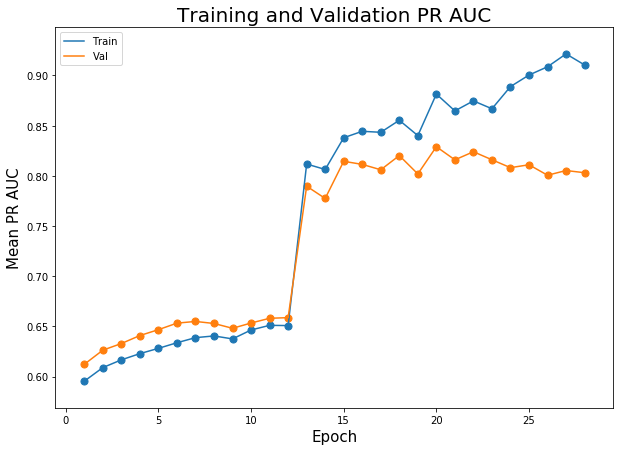

In [36]:
pr_auc_history_train = train_metric_callback.get_pr_auc_history()
pr_auc_history_val = val_callback.get_pr_auc_history()

plt.figure(figsize=(10, 7))
plot_with_dots(plt, pr_auc_history_train[-1])
plot_with_dots(plt, pr_auc_history_val[-1])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean PR AUC', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation PR AUC', fontsize=20)
plt.savefig('pr_auc_hist.png')

In [ ]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history_0.history['loss']+history_1.history['loss'])
plot_with_dots(plt, history_0.history['val_loss']+history_1.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

I left the model to train longer on my local GPU. I then upload the best model and plots from the model training.

In [ ]:
#model = load_model('../input/clouds-classifier-files/classifier_densenet169_epoch_21_val_pr_auc_0.8365921057512743.h5')

In [ ]:
Image("../input/clouds-classifier-files/loss_hist_densenet169.png")

In [ ]:
Image("../input/clouds-classifier-files/pr_auc_hist_densenet169.png")

# Selecting postprocessing thresholds

In [ ]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.90, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold][0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) 
                                 if thres == best_precision_threshold][0]
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing segmentation submission

Predicting cloud classes for test.

In [ ]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [ ]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

Segmentation results:

In [ ]:
submission = pd.read_csv('../input/densenet201cloudy/densenet201.csv')
submission.head()

In [ ]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [ ]:
print(f'{len(image_labels_empty.intersection(predictions_nonempty))} masks would be removed')

In [ ]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_segmentation_and_classifier.csv', index=None)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline, (please see [GradCAM: extracting masks from classifier](https://www.kaggle.com/samusram/gradcam-extracting-masks-from-classifier)),
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.